![Title slide](title_slide.png)

# 1. Introduction

Online news platforms rely heavily on user engagement to drive visibility, advertising revenue, and audience reach. One of the most widely used indicators of engagement is the number of times an article is shared on social media. Being able to predict an article’s popularity before publication is valuable for media companies, editors, and content strategists, yet it remains a challenging task due to the complex and often unpredictable nature of human behavior.

In this project, we formulate **a supervised regression problem** aimed at predicting the number of shares an online news article will receive. We use the **Online News Popularity dataset**, publicly available from the **UCI Machine Learning Repository** ([link](https://archive.ics.uci.edu/dataset/332/online+news+popularity)), which contains information on nearly 40,000 news articles published by *Mashable*. The dataset provides a rich set of features describing article content, sentiment, timing, and structure.

The target variable, `shares`, represents the total number of times an article was shared across multiple social media platforms. The feature set includes, among others, statistics related to word usage, sentiment polarity, presence of multimedia content, keyword metrics, and publication day. Due to the highly skewed distribution of the target variable, careful preprocessing and evaluation are required to obtain reliable and interpretable models.

The main objectives of this project are:
- To explore and preprocess the dataset in a reproducible and well-documented manner,
- To train and tune multiple regression models with different levels of complexity,
- To compare model performance using appropriate regression metrics,
- To analyze prediction errors and understand model limitations,
- To reflect on ethical considerations related to popularity-based prediction systems.

To address these objectives, we experiment with **three regression algorithms**. 

# 2. Data Preprocessing

In [108]:
# Libraries import
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV



In [76]:
csv_path = 'OnlineNewsPopularity.csv'

df = pd.read_csv(csv_path)
print(f'Loaded local file: {csv_path}')
display(df.head())


Loaded local file: OnlineNewsPopularity.csv


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [77]:
# Show column names cleanly
cols = df.columns.tolist()
print("Number of columns:", len(cols))
for c in cols:
    print(repr(c))

Number of columns: 61
'url'
' timedelta'
' n_tokens_title'
' n_tokens_content'
' n_unique_tokens'
' n_non_stop_words'
' n_non_stop_unique_tokens'
' num_hrefs'
' num_self_hrefs'
' num_imgs'
' num_videos'
' average_token_length'
' num_keywords'
' data_channel_is_lifestyle'
' data_channel_is_entertainment'
' data_channel_is_bus'
' data_channel_is_socmed'
' data_channel_is_tech'
' data_channel_is_world'
' kw_min_min'
' kw_max_min'
' kw_avg_min'
' kw_min_max'
' kw_max_max'
' kw_avg_max'
' kw_min_avg'
' kw_max_avg'
' kw_avg_avg'
' self_reference_min_shares'
' self_reference_max_shares'
' self_reference_avg_sharess'
' weekday_is_monday'
' weekday_is_tuesday'
' weekday_is_wednesday'
' weekday_is_thursday'
' weekday_is_friday'
' weekday_is_saturday'
' weekday_is_sunday'
' is_weekend'
' LDA_00'
' LDA_01'
' LDA_02'
' LDA_03'
' LDA_04'
' global_subjectivity'
' global_sentiment_polarity'
' global_rate_positive_words'
' global_rate_negative_words'
' rate_positive_words'
' rate_negative_words'
' avg_

The dataset contains **61 variables**, including one target variable (`shares`) and a rich set of features describing article content, metadata, publication timing, and sentiment. For clarity, the features are grouped into meaningful categories below.


#### 1. Identifiers and Non-Predictive Features

- **`url`**: URL of the article (identifier, non-predictive)
- **`timedelta`**: Number of days between article publication and dataset acquisition (non-predictive)

These variables are excluded from modeling as they do not contain information available at prediction time or do not contribute to predicting popularity.


#### 2. Content Structure and Length Features

- **`n_tokens_title`**: Number of words in the article title  
- **`n_tokens_content`**: Number of words in the article content  
- **`average_token_length`**: Average word length in the content  
- **`num_keywords`**: Number of keywords in the article metadata  

These features capture the **length and structural complexity** of the article.


#### 3. Lexical Diversity and Text Composition

- **`n_unique_tokens`**: Proportion of unique words in the content  
- **`n_non_stop_words`**: Proportion of non-stop words  
- **`n_non_stop_unique_tokens`**: Proportion of unique non-stop words  

These variables describe **lexical richness and vocabulary diversity**, which may influence reader engagement.


#### 4. Hyperlinks and Multimedia Content

- **`num_hrefs`**: Number of external links in the article  
- **`num_self_hrefs`**: Number of links to other Mashable articles  
- **`num_imgs`**: Number of images  
- **`num_videos`**: Number of embedded videos  

These features reflect **content richness and interactivity**.


#### 5. Data Channel Indicators

Binary variables indicating the article’s category:

- **`data_channel_is_lifestyle`**
- **`data_channel_is_entertainment`**
- **`data_channel_is_bus`**
- **`data_channel_is_socmed`**
- **`data_channel_is_tech`**
- **`data_channel_is_world`**

These variables capture thematic differences that may affect popularity.


#### 6. Keyword Popularity Statistics

Statistics describing the popularity of keywords associated with the article:

- **Worst-performing keywords**:  
  - `kw_min_min`, `kw_max_min`, `kw_avg_min`
- **Best-performing keywords**:  
  - `kw_min_max`, `kw_max_max`, `kw_avg_max`
- **Average keyword performance**:  
  - `kw_min_avg`, `kw_max_avg`, `kw_avg_avg`

These features summarize historical keyword performance in terms of shares.


#### 7. Self-Reference Popularity Features

- **`self_reference_min_shares`**: Minimum shares of referenced Mashable articles  
- **`self_reference_max_shares`**: Maximum shares of referenced Mashable articles  
- **`self_reference_avg_sharess`**: Average shares of referenced Mashable articles  

These variables capture **internal popularity signals** based on related content.


#### 8. Publication Timing Features

- **Weekday indicators**:  
  - `weekday_is_monday`, `weekday_is_tuesday`, `weekday_is_wednesday`,  
    `weekday_is_thursday`, `weekday_is_friday`, `weekday_is_saturday`, `weekday_is_sunday`
- **`is_weekend`**: Indicates whether the article was published on a weekend  

These features model **temporal effects** in content popularity.


#### 9. Topic Distribution (LDA Features)

- **`LDA_00` – `LDA_04`**: Degree of association with five latent topics derived using Latent Dirichlet Allocation (LDA)

These variables describe the **thematic composition** of the article.


#### 10. Sentiment and Subjectivity Features (Content)

- **`global_subjectivity`**: Overall text subjectivity  
- **`global_sentiment_polarity`**: Overall sentiment polarity  
- **`global_rate_positive_words`**: Proportion of positive words  
- **`global_rate_negative_words`**: Proportion of negative words  
- **`rate_positive_words`**: Proportion of positive words among non-neutral tokens  
- **`rate_negative_words`**: Proportion of negative words among non-neutral tokens  
- **Polarity statistics**:  
  - `avg_positive_polarity`, `min_positive_polarity`, `max_positive_polarity`  
  - `avg_negative_polarity`, `min_negative_polarity`, `max_negative_polarity`  

These features quantify the **emotional tone and intensity** of the article text.


#### 11. Sentiment and Subjectivity Features (Title)

- **`title_subjectivity`**: Subjectivity of the article title  
- **`title_sentiment_polarity`**: Sentiment polarity of the title  
- **`abs_title_subjectivity`**: Absolute subjectivity level of the title  
- **`abs_title_sentiment_polarity`**: Absolute sentiment polarity level of the title  

These variables focus specifically on the **emotional impact of the headline**.


#### 12. Target Variable

- **`shares`**: Number of times the article was shared on social media platforms  

This variable represents the **target** of the regression task and serves as a proxy for article popularity.

In [78]:
# Remove leading spaces from column names
df.columns = df.columns.str.strip()

In [79]:
# Basic checks
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)

# Missing values
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values (top):\n", missing.head(10))

# Duplicates
print("\nDuplicate rows:", df.duplicated().sum())

Shape: (39644, 61)

Columns: ['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words

The dataset consists of **39,644 observations** and **61 variables**, including one target variable (`shares`) and a rich set of numerical and categorical features describing article content, sentiment, timing and structure.  
The dataset is fully populated, simplifying preprocessing and ensuring that modeling results are not influenced by missing-data handling strategies.

# 3. Explanatory Data Analysis and Feature Engineering

### Correlation Heatmap

Let's check correlation heatmap.

In [80]:
corr_matrix = df.corr(numeric_only=True)

# Correlation with target
target_corr = corr_matrix["shares"].sort_values(ascending=False)

display(target_corr.head(10))
display(target_corr.tail(10))

shares                        1.000000
kw_avg_avg                    0.110413
LDA_03                        0.083771
kw_max_avg                    0.064306
self_reference_avg_sharess    0.057789
self_reference_min_shares     0.055958
self_reference_max_shares     0.047115
num_hrefs                     0.045404
kw_avg_max                    0.044686
kw_min_avg                    0.039551
Name: shares, dtype: float64

rate_positive_words             -0.013241
data_channel_is_tech            -0.013253
LDA_04                          -0.016622
data_channel_is_entertainment   -0.017006
min_negative_polarity           -0.019297
max_negative_polarity           -0.019300
average_token_length            -0.022007
avg_negative_polarity           -0.032029
data_channel_is_world           -0.049497
LDA_02                          -0.059163
Name: shares, dtype: float64

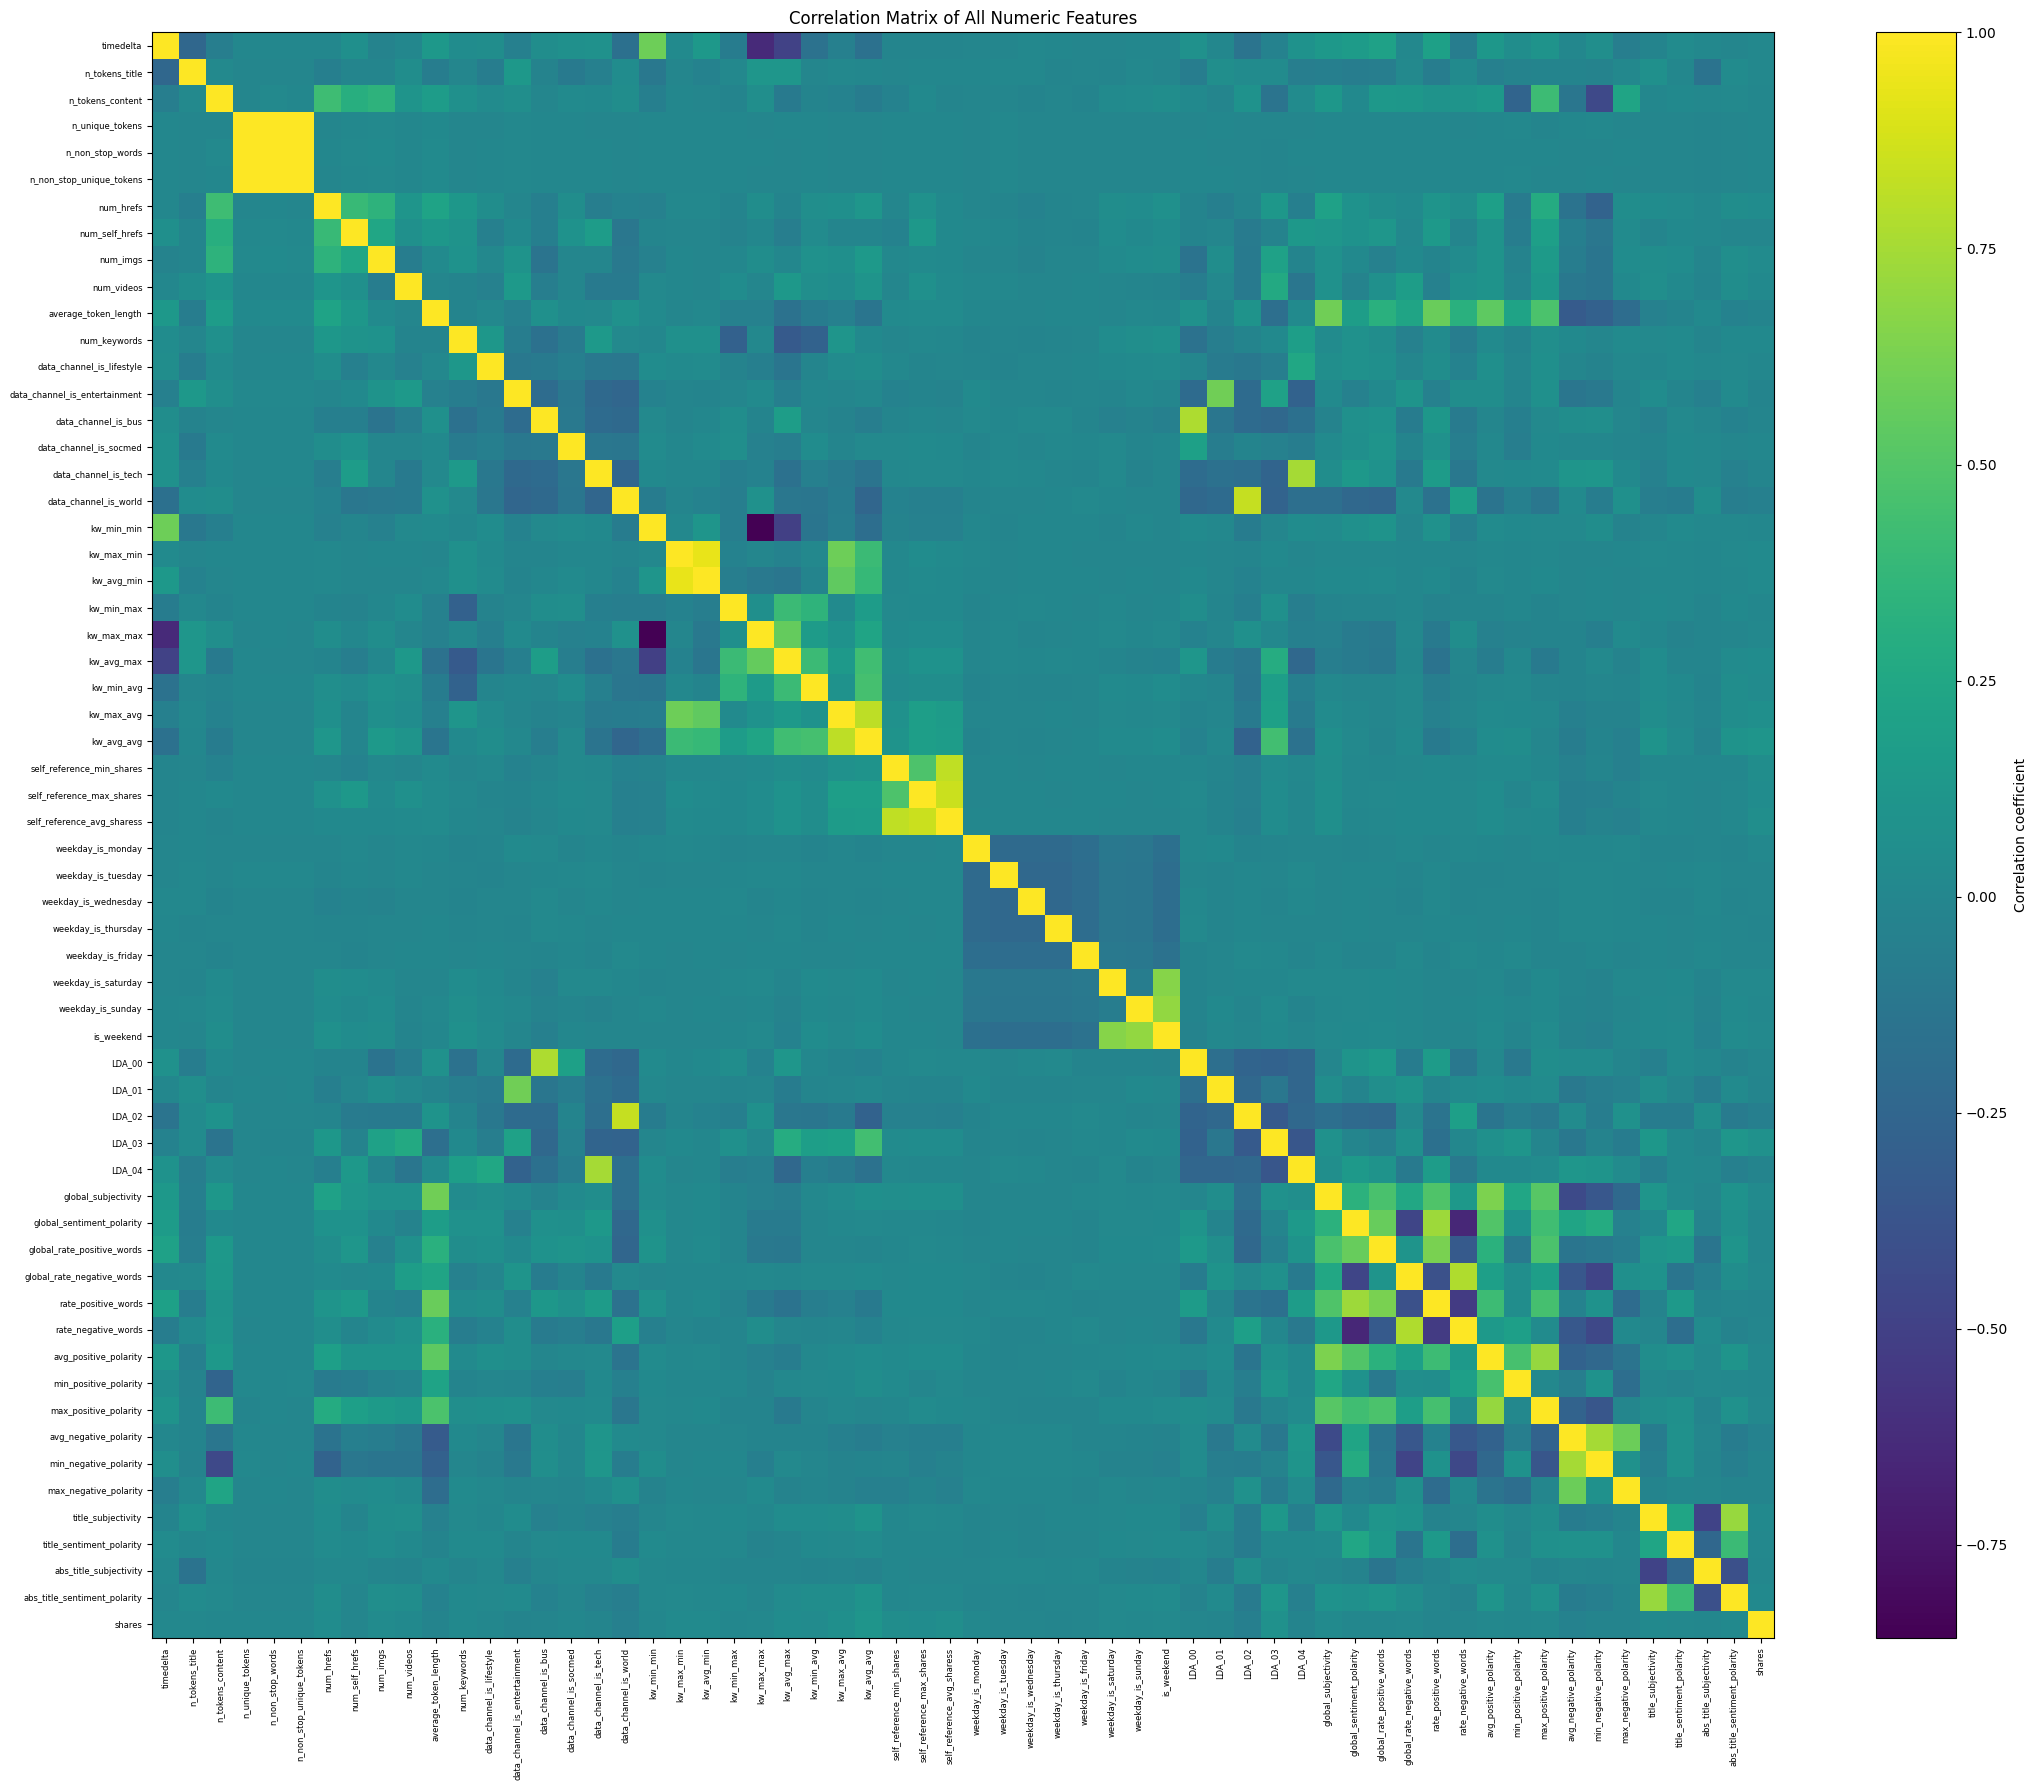

In [81]:
plt.figure(figsize=(22, 18))
plt.imshow(corr_matrix, aspect="auto")
plt.colorbar(label="Correlation coefficient")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=6)
plt.title("Correlation Matrix of All Numeric Features")
plt.tight_layout()
plt.show()

Feature aggregation was applied to groups of highly correlated variables identified during correlation analysis. By combining redundant features into representative summary measures, multicollinearity was reduced while preserving the underlying predictive information. This approach improves model stability, interpretability and computational efficiency without relying on aggressive manual feature removal.

In [82]:
df["kw_worst_mean"] = df[["kw_min_min", "kw_max_min", "kw_avg_min"]].mean(axis=1)
df["kw_best_mean"]  = df[["kw_min_max", "kw_max_max", "kw_avg_max"]].mean(axis=1)
df["kw_avg_mean"]   = df[["kw_min_avg", "kw_max_avg", "kw_avg_avg"]].mean(axis=1)

df = df.drop(columns=[
    "kw_min_min", "kw_max_min", "kw_avg_min",
    "kw_min_max", "kw_max_max", "kw_avg_max",
    "kw_min_avg", "kw_max_avg", "kw_avg_avg"
])

In [83]:
df["self_reference_mean_shares"] = df[
    ["self_reference_min_shares",
     "self_reference_max_shares",
     "self_reference_avg_sharess"]
].mean(axis=1)

df = df.drop(columns=[
    "self_reference_min_shares",
    "self_reference_max_shares",
    "self_reference_avg_sharess"
])

In [84]:
df["content_sentiment_strength"] = (
    df["global_rate_positive_words"] +
    df["global_rate_negative_words"]
)

df["content_polarity_range"] = (
    df["max_positive_polarity"] - df["min_negative_polarity"]
)

In [85]:
n_rows, n_cols = df.shape
print(f"Dataset shape after aggregation: {n_rows} rows, {n_cols} columns")

Dataset shape after aggregation: 39644 rows, 55 columns


We get rid of weekday and we will make it categorical and encode it later.

In [86]:
# Identify weekday dummy columns
weekday_cols = [c for c in df.columns if c.startswith("weekday_is_")]

# Create categorical weekday variable
df["weekday"] = (
    df[weekday_cols]
    .idxmax(axis=1)
    .str.replace("weekday_is_", "")
)

# Drop redundant columns
df = df.drop(columns=weekday_cols + ["is_weekend"])

In [87]:
print(df["weekday"].value_counts())
print("Number of columns after weekday removal:", df.shape[1])

weekday
wednesday    7435
tuesday      7390
thursday     7267
monday       6661
friday       5701
sunday       2737
saturday     2453
Name: count, dtype: int64
Number of columns after weekday removal: 48


### Target Variable Analysis

Shares is our target variable

In [88]:
# Summary of target
display(df["shares"].describe())

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

- The target variable, `shares`, displays a **highly right-skewed distribution**.
- The **median** number of shares is **1,400**, while the **mean** is substantially higher at **3,395**, indicating the presence of extreme values.
- The **standard deviation** (**11,627**) is more than three times the mean, reflecting **very high variability** in article popularity.
- The **maximum observed value** reaches **843,300 shares**, showing that a small number of articles achieve **viral popularity**, but they are perceived as outliers.
- In contrast, the majority of articles receive **relatively modest engagement**, with 75% of articles having fewer than **2,800 shares**.
- These characteristics motivate the use of a **logarithmic transformation of the target variable** in the modeling stage to reduce skewness and mitigate the influence of outliers.

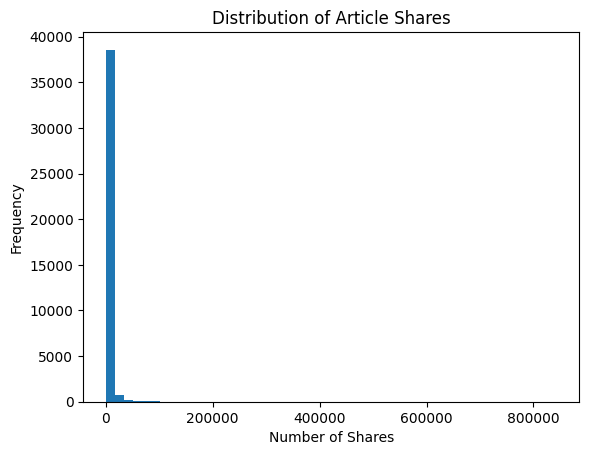

In [89]:
plt.figure()
plt.hist(df["shares"], bins=50)
plt.xlabel("Number of Shares")
plt.ylabel("Frequency")
plt.title("Distribution of Article Shares")
plt.show()

The histogram of `shares` reveals a strongly right-skewed distribution, with most articles receiving relatively few shares and a small number of viral articles forming a long right tail. This extreme skewness causes the majority of observations to cluster near the lower end of the distribution.

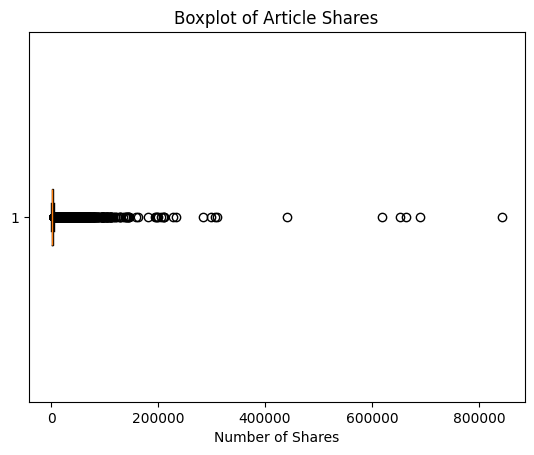

In [90]:
plt.figure()
plt.boxplot(df["shares"], vert=False)
plt.xlabel("Number of Shares")
plt.title("Boxplot of Article Shares")
plt.show()

For better readibility, the boxplot without extreme outliers was created.

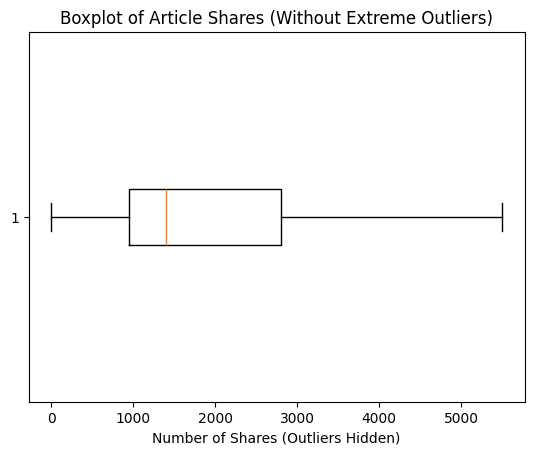

In [91]:
plt.figure()
plt.boxplot(df["shares"], vert=False, showfliers=False)
plt.xlabel("Number of Shares (Outliers Hidden)")
plt.title("Boxplot of Article Shares (Without Extreme Outliers)")
plt.show()

### Predictor Variables Analysis

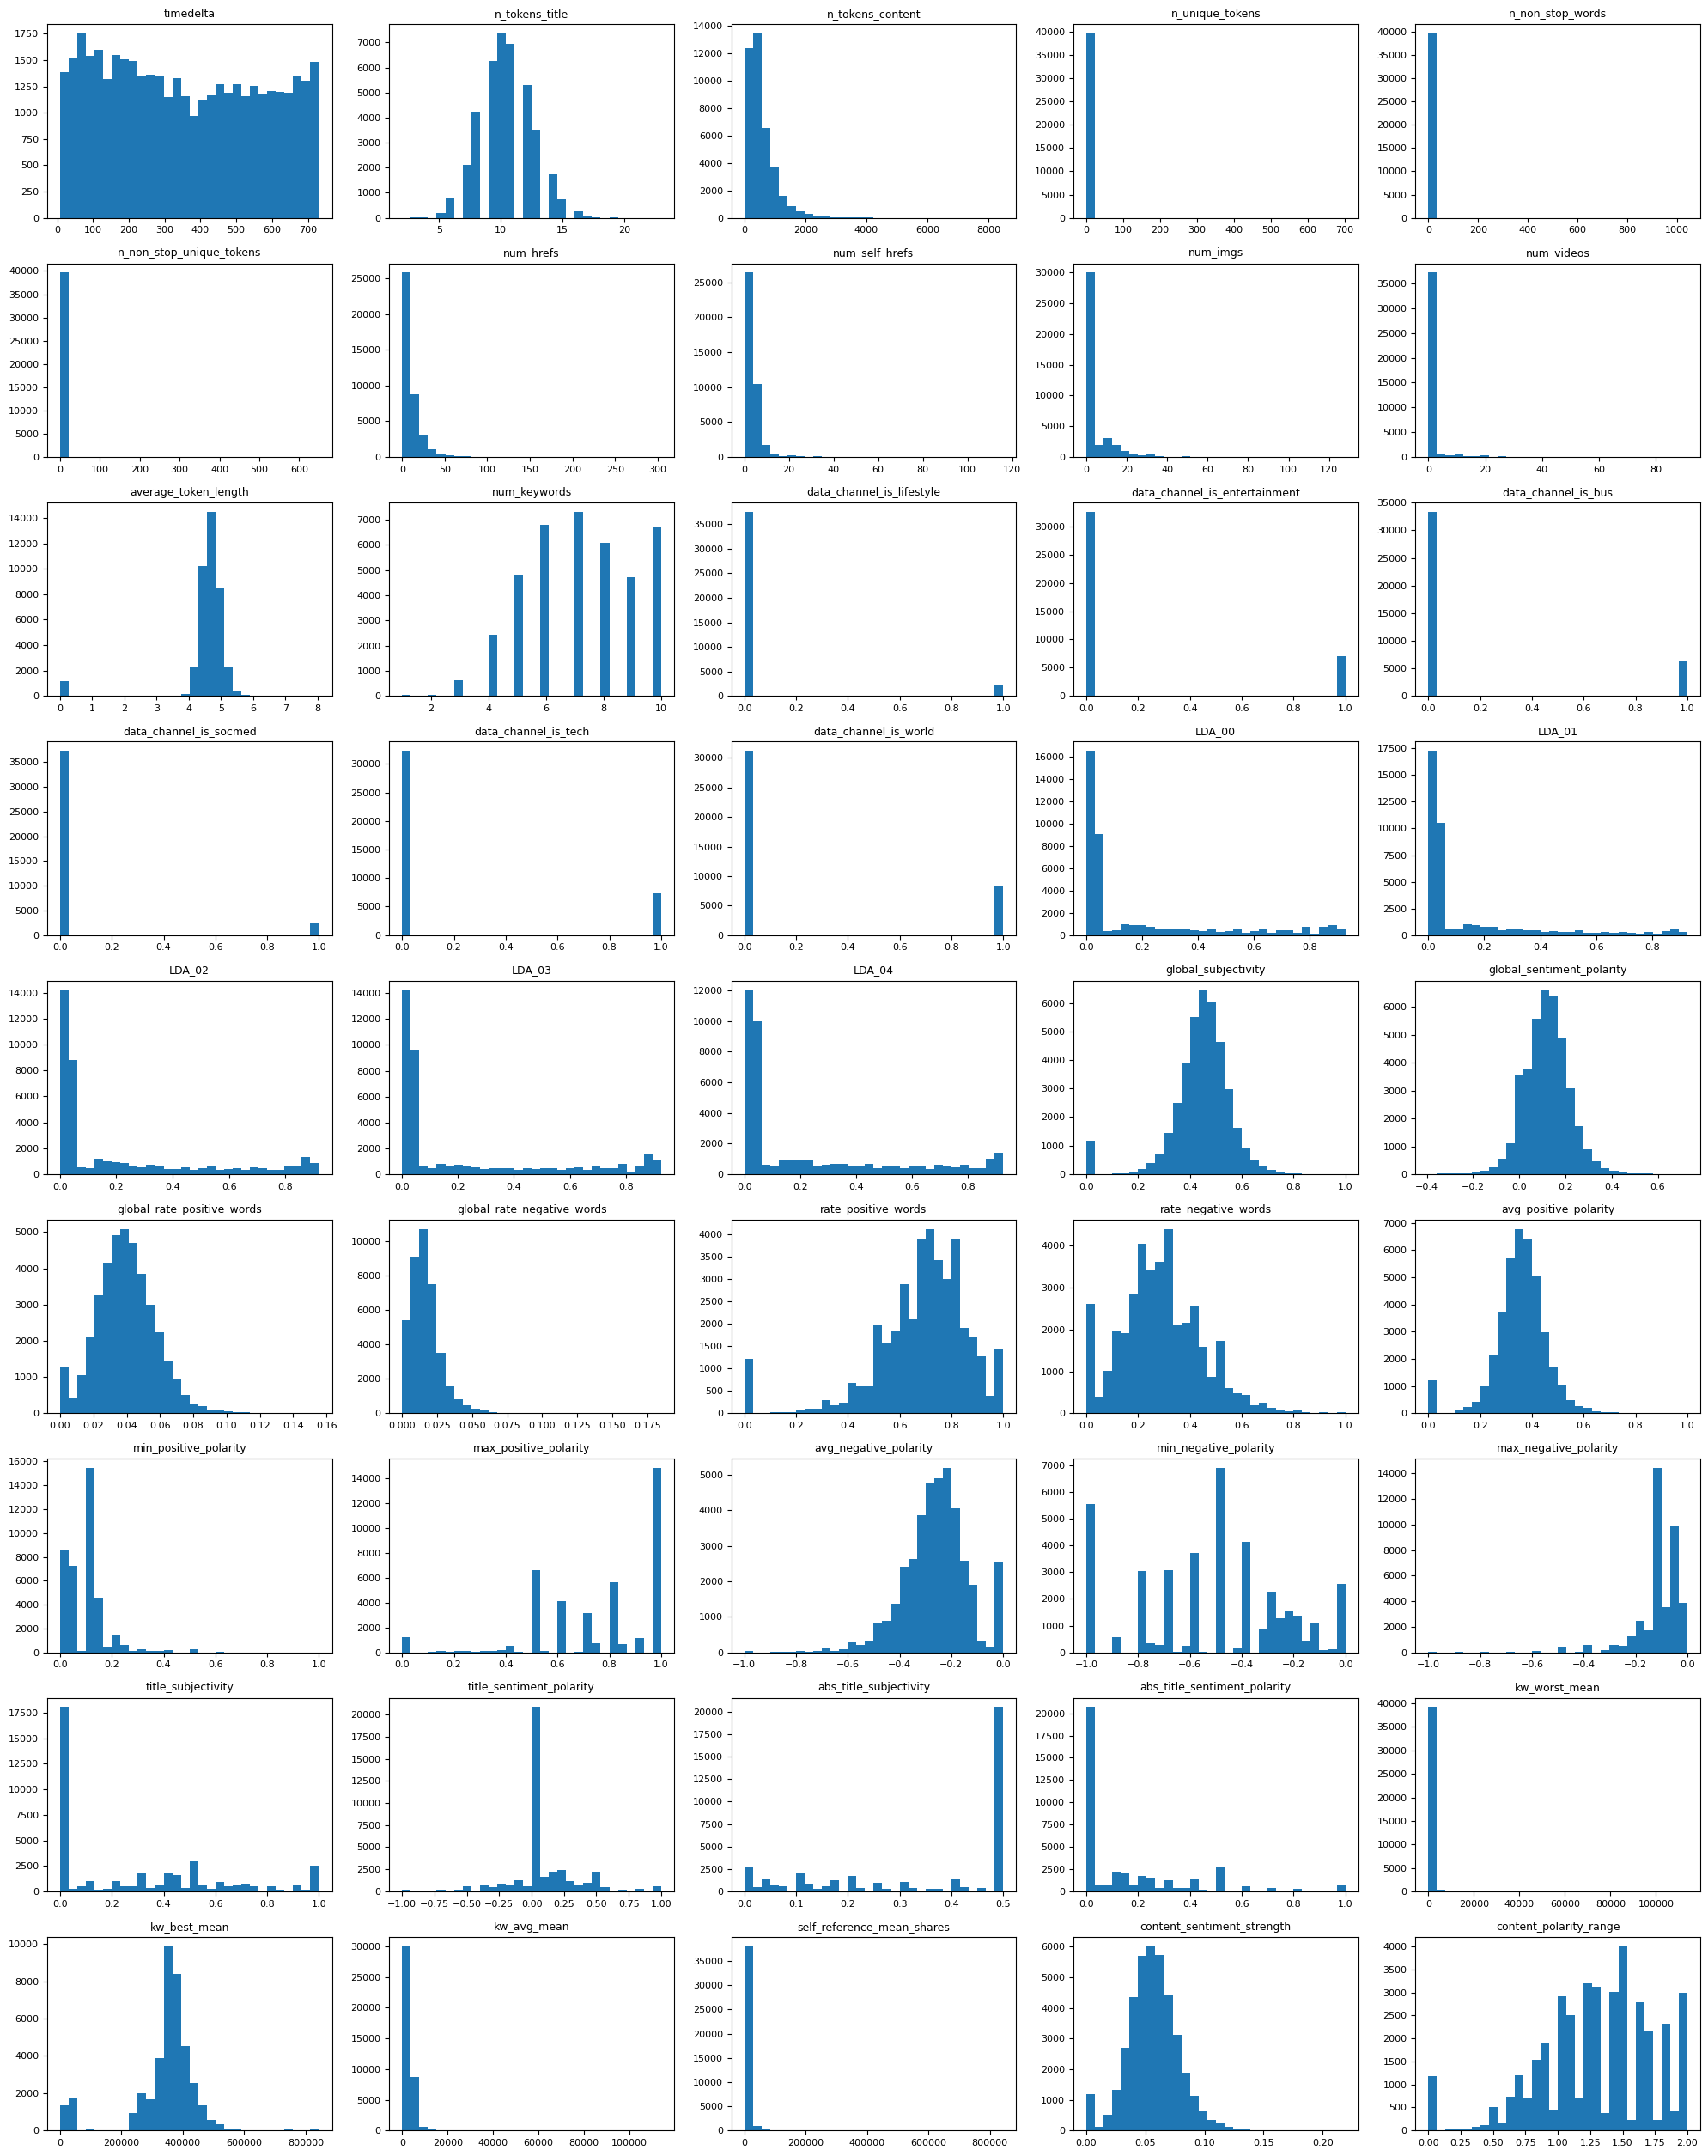

In [92]:
# Select numeric columns only, exclude target
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "shares"]  # predictors only

# Grid layout
n_cols = 5  # adjust (e.g., 4–6) depending on your screen
n_plots = len(numeric_cols)
n_rows = math.ceil(n_plots / n_cols)

# Create the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 2.8*n_rows))
axes = axes.flatten()

# Plot each histogram
for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col].dropna(), bins=30)
    axes[i].set_title(col, fontsize=9)
    axes[i].tick_params(axis="both", labelsize=8)

# Hide unused subplots (if any)
for j in range(n_plots, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

The distributional analysis of predictor variables shows substantial heterogeneity across feature types. While several count-based variables exhibit strong right skewness and long-tailed distributions, many sentiment, topic and indicator features are bounded or approximately symmetric. 


### Train-Test Split

In [93]:
# Features: drop target + non-predictive text/id columns
X = df.drop(columns=["shares", "url", "timedelta"], errors="ignore")

# Target: keep raw for splitting
y = df["shares"]

# Split
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Log-transform target AFTER split
y_train = np.log1p(y_train_raw)
y_test  = np.log1p(y_test_raw)

### Encoding

In [94]:
# Columns to log-transform (must exist in X_train)
log_features = [
    "n_tokens_content", "num_hrefs", "num_self_hrefs",
    "num_imgs", "num_videos", "num_keywords",
    "kw_worst_mean", "kw_avg_mean", "self_reference_mean_shares"
]
log_features = [c for c in log_features if c in X_train.columns]

categorical_features = ["weekday"]
numeric_features = [c for c in X_train.columns if c not in categorical_features]

other_numeric = [c for c in numeric_features if c not in log_features]

log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

preprocess = ColumnTransformer(
    transformers=[
        ("log_num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("log", log_transformer),
            ("scaler", StandardScaler()),
        ]), log_features),

        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), other_numeric),

        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

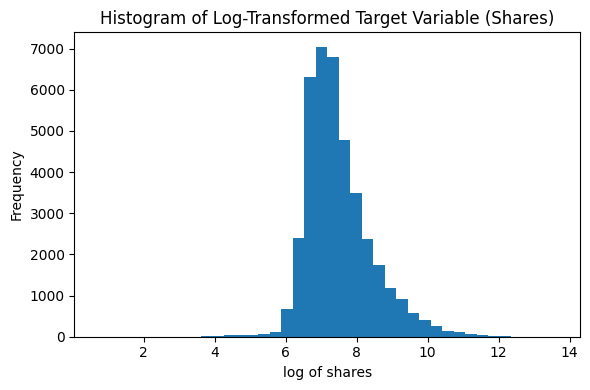

In [95]:
# Log-transform target for visualization
log_shares = np.log1p(df["shares"])

plt.figure(figsize=(6, 4))
plt.hist(log_shares, bins=40)
plt.xlabel("log of shares")
plt.ylabel("Frequency")
plt.title("Histogram of Log-Transformed Target Variable (Shares)")
plt.tight_layout()
plt.show()

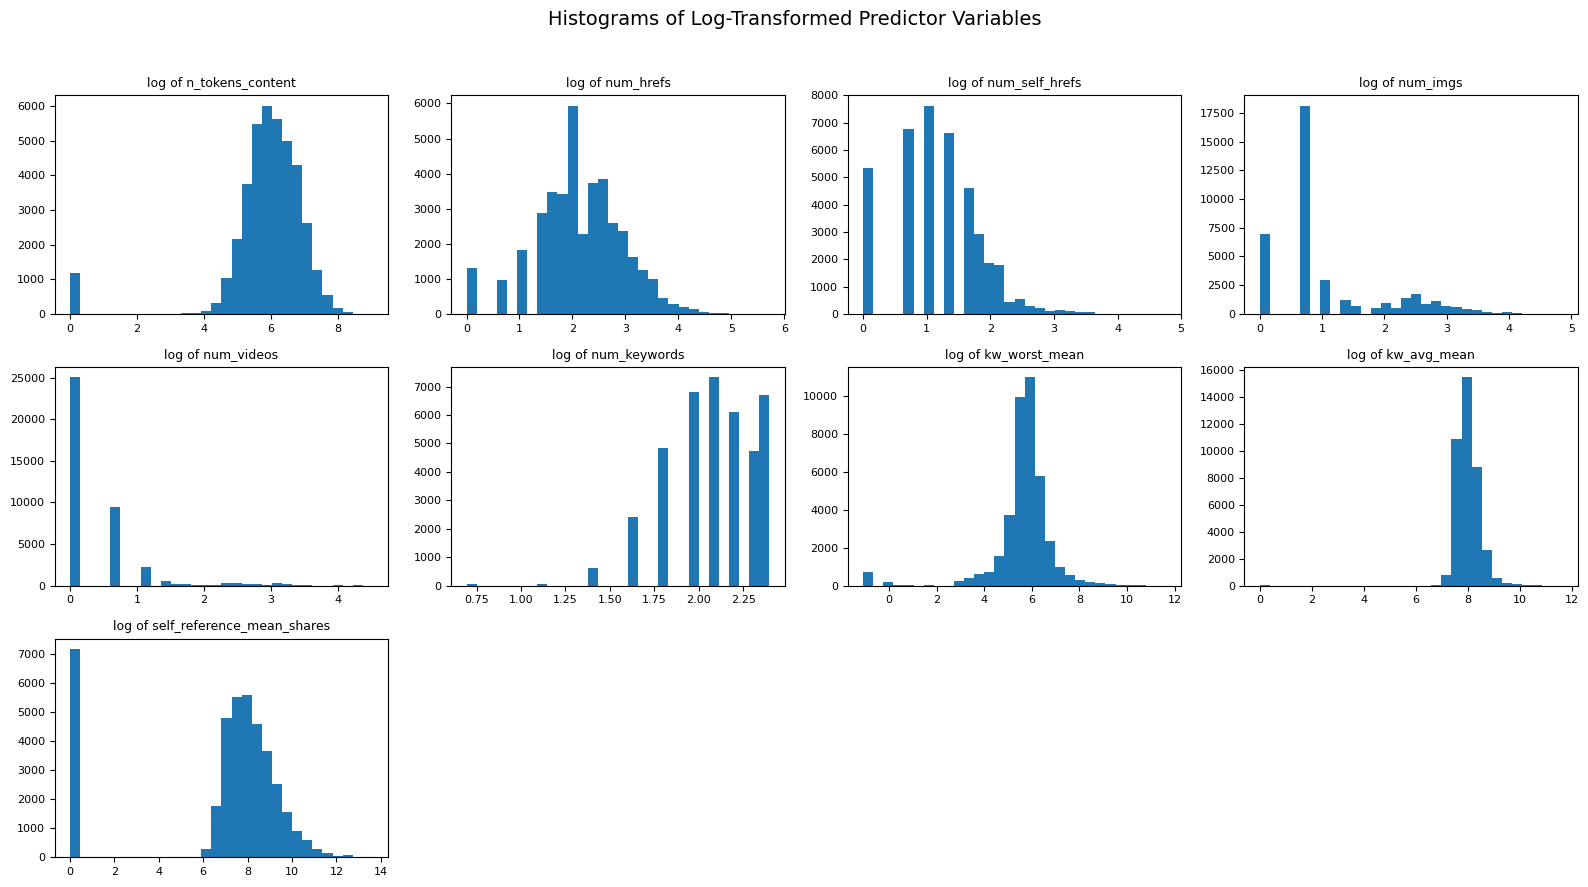

In [96]:
# Keep only columns that exist (safety)
log_features = [c for c in log_features if c in df.columns]

# Layout
n_cols = 4
n_plots = len(log_features)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(log_features):
    axes[i].hist(np.log1p(df[col]), bins=30)
    axes[i].set_title(f"log of {col}", fontsize=9)
    axes[i].tick_params(axis="both", labelsize=8)

# Hide unused subplots
for j in range(n_plots, len(axes)):
    axes[j].axis("off")

plt.suptitle("Histograms of Log-Transformed Predictor Variables", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Applying a logarithmic transformation to the target variable substantially reduces the extreme right skewness observed in the original distribution of article shares. The transformed target exhibits a more compact distribution with reduced influence of outliers, making it more suitable for regression modeling.

#### Predictor vs Target Variable

Content length vs Shares

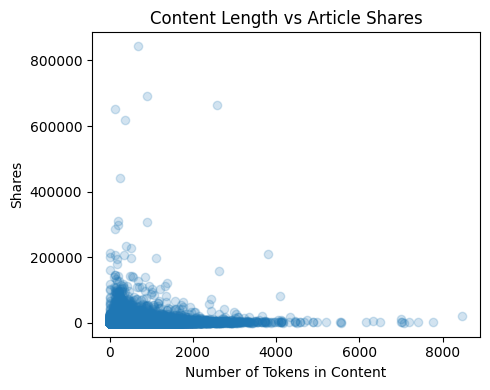

In [97]:
plt.figure(figsize=(5,4))
plt.scatter(df["n_tokens_content"], df["shares"], alpha=0.2)
plt.xlabel("Number of Tokens in Content")
plt.ylabel("Shares")
plt.title("Content Length vs Article Shares")
plt.tight_layout()
plt.show()

Weekday vs share

<Figure size 700x400 with 0 Axes>

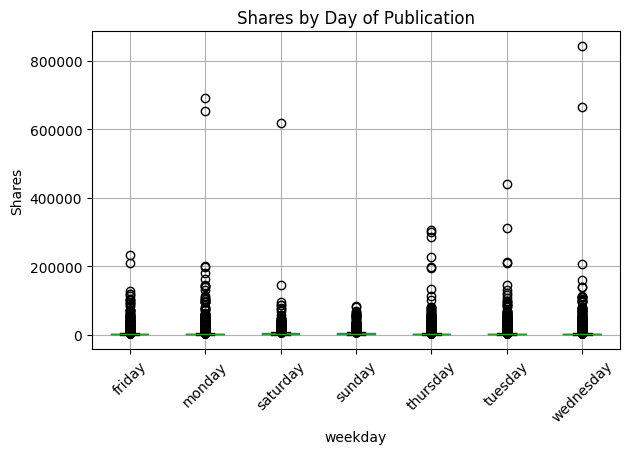

In [98]:
plt.figure(figsize=(7,4))
df.boxplot(column="shares", by="weekday")
plt.suptitle("")
plt.title("Shares by Day of Publication")
plt.ylabel("Shares")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Average Shares by Content Channel

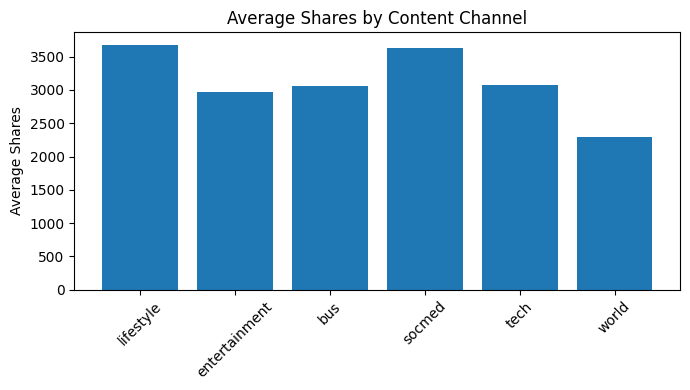

In [99]:
channels = [c for c in df.columns if c.startswith("data_channel_is_")]

means = {
    c.replace("data_channel_is_", ""):
    df.loc[df[c] == 1, "shares"].mean()
    for c in channels
}

plt.figure(figsize=(7,4))
plt.bar(means.keys(), means.values())
plt.ylabel("Average Shares")
plt.title("Average Shares by Content Channel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sentiment vs Shares

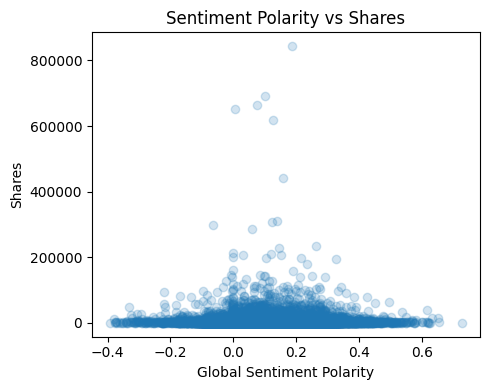

In [100]:
plt.figure(figsize=(5,4))
plt.scatter(df["global_sentiment_polarity"], df["shares"], alpha=0.2)
plt.xlabel("Global Sentiment Polarity")
plt.ylabel("Shares")
plt.title("Sentiment Polarity vs Shares")
plt.tight_layout()
plt.show()

##### Exploratory Data Analysis Summary

The exploratory analysis showed that the dataset contains no missing values and includes a large number of heterogeneous predictors. The target variable, number of shares, exhibits a highly right-skewed distribution, which motivated a logarithmic transformation. Several count-based predictors were also strongly right-skewed and were selected for logarithmic transformation. Correlation analysis revealed substantial redundancy among groups of features, leading to feature aggregation and more compact representations. Overall, individual predictors show weak to moderate relationships with the target, suggesting that article popularity depends on complex, non-linear interactions.

# 4. Modelling

## Random Forest

In [102]:
# Baseline Random Forest 
rf_baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit model
rf_baseline.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_baseline.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Baseline RMSE: {rmse_rf:.3f}")
print(f"Random Forest Baseline R²: {r2_rf:.3f}")

Random Forest Baseline RMSE: 0.853
Random Forest Baseline R²: 0.150


## Elastic Net

## XGBoost

# 5. Hyperparameters Tuning

## Random Forest

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(X_tr.shape, X_val.shape)

(19028, 45) (4758, 45)


In [116]:
from sklearn.metrics import mean_squared_error, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)  # negative RMSE for "maximize" convention

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [119]:
from sklearn.model_selection import RandomizedSearchCV

rf_param_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 8, 12, 16, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.5],
    "model__bootstrap": [True]
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring=rmse_scorer,
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_tr, y_tr)
print("Best RF params:", rf_search.best_params_)
print("Best CV (neg RMSE):", rf_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/Weronika/Library/CloudStorage/OneDrive-Osobisty/Pulpit/Data-Science/Year 2 semester 3/Machine Learning 2/ML2_final_project/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'model__n_estimators': 600, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__bootstrap': True}
Best CV (neg RMSE): -0.8606527156566026


In [120]:
best_rf = rf_search.best_estimator_
y_val_pred = best_rf.predict(X_val)

val_rmse = rmse(y_val, y_val_pred)
print("Validation RMSE (log scale):", val_rmse)

Validation RMSE (log scale): 0.8783205015196075


# 6. Model Evaluation

In [ ]:
best_rf.fit(X_train, y_train)
y_test_pred = best_rf.predict(X_test)
test_rmse = rmse(y_test, y_test_pred)
print("Test RMSE (log scale):", test_rmse)

# 7. Models comparison

# 8. Conclusions